# Import packages

In [1]:
from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets
import numpy as np
import tensorflow as tf
import cv2 
import os
from tensorflow.keras import layers
from scipy.interpolate import splprep, splev
import pandas as pd
import numpy
from pathlib import Path
from scipy.spatial import distance
import math
import sys
from scipy.ndimage import gaussian_filter
from random import choice
import time
import panel as pn
pn.extension()
import matplotlib.pyplot as plt

%load_ext autotime

time: 354 µs (started: 2022-07-04 04:21:35 +00:00)


# Load original image, bone area, tooth and cej line masks

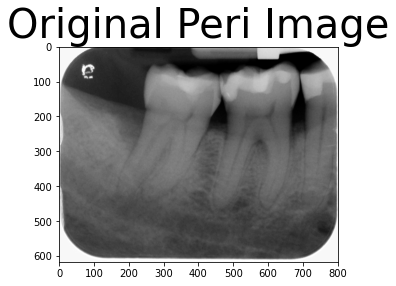

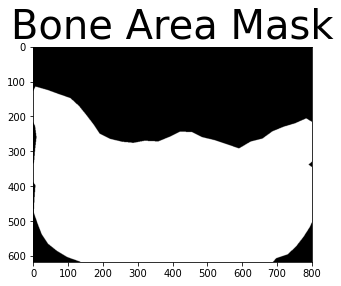

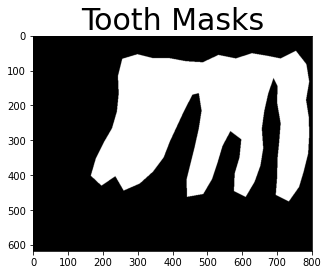

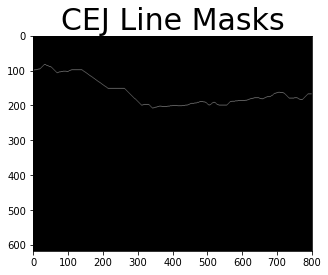

time: 775 ms (started: 2022-07-04 04:21:35 +00:00)


In [2]:
image_file_name = 'sample_1.png'
image = cv2.imread('sample_images/peri_images/'+ image_file_name,0)
img_bone_area = cv2.imread('sample_images/masks/'+ 'bone_area_'+  image_file_name,0)
img_tooth = cv2.imread('sample_images/masks/'+ 'tooth_'+  image_file_name,0)
img_cej = cv2.imread('sample_images/masks/'+ 'cej_line_'+  image_file_name,0)


plt.figure(figsize = (5,5))
plt.title("Original Peri Image",fontsize = 40)
plt.imshow(image, cmap= 'gray')

plt.figure(figsize = (5,5))
plt.title("Bone Area Mask",fontsize = 40)
plt.imshow(img_bone_area, cmap= 'gray')

plt.figure(figsize = (5,5))
plt.title("Tooth Masks",fontsize = 30)
plt.imshow(img_tooth, cmap= 'gray')


plt.figure(figsize = (5,5))
plt.title("CEJ Line Masks",fontsize = 30)
plt.imshow(img_cej, cmap= 'gray')



# Necessary Function for image post processing

In [3]:
def find_start_position(image,point):
    for n in range(point[0], image.shape[1]):
        max_value = 0.
        max_value_index= 0
        for m in range(point[1],image.shape[0]):
             if image[m,n] > max_value:
                max_value = image[m,n]
                max_value_index= m
        if(max_value>0):
            break
    start = (n,max_value_index)
    return start

def find_continuous_line_for_tooth_bone_area(image, point):
    points_list=[]
    points_list.append(point)
    
    
    while(1):
        current_x = points_list[-1][0]
        current_y = points_list[-1][1]
        
        if current_x+1>image.shape[1]-1:
            break
            
        value = image[:, current_x+1]
        maximum = max(value)
        if maximum==0:
            break
        else:
            current_y = np.nonzero(value)
            points_list.append((current_x+1, current_y[0][0]))
    return points_list[1:]

def findIntersection(x1,y1,x2,y2,x3,y3,x4,y4):
        px= ( (x1*y2-y1*x2)*(x3-x4)-(x1-x2)*(x3*y4-y3*x4) ) / ( (x1-x2)*(y3-y4)-(y1-y2)*(x3-x4) ) 
        py= ( (x1*y2-y1*x2)*(y3-y4)-(y1-y2)*(x3*y4-y3*x4) ) / ( (x1-x2)*(y3-y4)-(y1-y2)*(x3-x4) )
        return (int(px), int(py))

time: 1.15 ms (started: 2022-07-04 04:21:36 +00:00)


# For tooth extraction

In [4]:
def tooth_extract(img_tooth, img_cej, img_bone_area):
    my_distance_1 = 30#30
    my_distance_2 = 80#50
    my_contour = 12000#2000


    tooth_dictionary = {}

    #####for cej line and tooth intersection

    bitwise_and_image_tooth_cej = cv2.bitwise_and(img_tooth, img_cej)
    #cv2.imwrite('choity.png', bitwise_and_image_tooth_cej)
    segments = []

    initial = (0,0)
    while initial[0] < bitwise_and_image_tooth_cej.shape[1]:
        start_line = find_start_position(bitwise_and_image_tooth_cej,initial)
        all_points = []
        all_points.append(start_line)
        continuous_points = find_continuous_line_for_tooth_bone_area(bitwise_and_image_tooth_cej, start_line)
        if(len(continuous_points))>1:
            all_points.extend(continuous_points)
            d = distance.euclidean(all_points[0], all_points[-1])
            if(d>my_distance_1):
                segments.append(all_points)
        
        last_point = all_points[-1]
        initial = (last_point[0]+1, max(last_point[1]-50, 0))
    cej_line_tooth_segments =[]

    for i_, s in enumerate(segments):
        cej_line_tooth_segments.append((i_, s[0],s[-1]))
        tooth_dictionary['tooth_'+str(i_)] = [(0,(s[0],s[-1]))]

    ######for bone area and tooth intersection

    ret,thresh = cv2.threshold(img_bone_area,127,255,0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    img_bone_area_contours = np.zeros((img_bone_area.shape[0], img_bone_area.shape[1]),  dtype =numpy.uint8)

    cv2.drawContours(img_bone_area_contours, contours, -1, (255), 3)
    
    

    bitwise_and_image_tooth_bone_area = cv2.bitwise_and(img_tooth, img_bone_area_contours)
    
    cv2.imwrite('choity.png', bitwise_and_image_tooth_bone_area)

    segments_debug = []

    initial = (0,0)
    while initial[0] < bitwise_and_image_tooth_bone_area.shape[1]:
        start_line = find_start_position(bitwise_and_image_tooth_bone_area,initial)
        all_points = []
        all_points.append(start_line)
        continuous_points = find_continuous_line_for_tooth_bone_area(bitwise_and_image_tooth_bone_area, start_line)
        if(len(continuous_points)==0):
            bitwise_and_image_tooth_bone_area[start_line[1],start_line[0]] = 0
        else:
            all_points.extend(continuous_points)
            d = distance.euclidean(all_points[0], all_points[-1])
            if(d>my_distance_2):
                segments_debug.append(all_points)

        last_point = all_points[-1]
        initial = (last_point[0]+1, max(last_point[1]-50, 0))

    tooth_bone_segment = []
    for i_, s in enumerate(segments_debug):
        tooth_bone_segment.append((i_, s[0],s[-1]))
        tooth_dictionary['tooth_'+str(i_)].append((1,(s[0],s[-1])))
    
    


    #####for tooth moments
    bitwise_and_image = cv2.bitwise_and(img_tooth, img_bone_area)
    
    
    ret,thresh = cv2.threshold(bitwise_and_image,127,255,0)
    img_tooth_contours = np.zeros((img_tooth.shape[0], img_tooth.shape[1]),  dtype =numpy.uint8)
    ctrs, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    
    bigger_ctrs = []

    for big in ctrs:
        if cv2.contourArea(big)> my_contour:
            bigger_ctrs.append(big)

    contours = sorted(bigger_ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])


    p = 0
    #p = len(contours)-1
    name_p = len(contours)-1
    for i_,cnt in enumerate(contours):
        ####moments calculation for each contour
        for_draw_tooth_img = np.zeros((img_bone_area.shape[0], img_bone_area.shape[1]),  dtype =numpy.uint8)
        cv2.drawContours(for_draw_tooth_img, [cnt], -1, (255), -1)
        x,y,w,h = cv2.boundingRect(cnt)
        final_img_classification = cv2.addWeighted(img_bone_area, .5, img_tooth, .5, 0)
        final_img_classification = cv2.addWeighted(img_cej, 1, final_img_classification, 1, 0)
    
        left_side = min(tooth_dictionary['tooth_'+str(p)][0][1][0][0], x)
        right_side = max(tooth_dictionary['tooth_'+str(p)][0][1][1][0], x+w)
        final_img_classification_1 = final_img_classification[:,x:x+w]

        p +=1
        name_p -=1

        ######################
        M = cv2.moments(cnt)
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        tooth_dictionary['tooth_'+str(i_)].append((2,(cx,cy)))

        ###tooth and bone area middle point calculation

        tooth_middle_x = int((tooth_dictionary['tooth_'+str(i_)][1][1][0][0] + tooth_dictionary['tooth_'+str(i_)][1][1][1][0])/2)
        tooth_middle_y = int((tooth_dictionary['tooth_'+str(i_)][1][1][0][1] + tooth_dictionary['tooth_'+str(i_)][1][1][1][1])/2)
        tooth_dictionary['tooth_'+str(i_)].append((3,(tooth_middle_x,tooth_middle_y)))
        ###ccalculate slope and b
        if (tooth_middle_x == cx):
            cx = cx+1

        m = (tooth_middle_y - cy)/(tooth_middle_x - cx)
        b = cy - m * cx

        ####left root point and right root point using hull
        hull = cv2.convexHull(cnt)
        hull_points_list_left = []
        hull_points_list_right = []
        for hh in range(len(hull)):
            x3 = hull[hh][0][0]
            y3 = hull[hh][0][1]
            if m >= 0:
              if y3 >= m*x3 + b :
                hull_points_list_left.append((x3,y3))
              else:
                hull_points_list_right.append((x3,y3))

            else:
              if y3 < m*x3 + b :
                hull_points_list_left.append((x3,y3))
              else:
                hull_points_list_right.append((x3,y3))
        hull_points_list_left.sort(key = lambda x: x[1], reverse = True)
        hull_points_list_right.sort(key = lambda x: x[1], reverse = True)
        left_root = hull_points_list_left[0]
        right_root = hull_points_list_right[0]
        tooth_dictionary['tooth_'+str(i_)].append((4,(left_root,right_root)))

        theta = math.atan(m)
        if (theta>0):
            theta = math.pi + theta 
        length = 200
        x_left = int(left_root[0] + length * math.cos(theta))
        y_left = int(left_root[1] + length * math.sin(theta))
        x_right = int(right_root[0] + length * math.cos(theta))
        y_right = int(right_root[1] + length * math.sin(theta))

        tooth_dictionary['tooth_'+str(i_)].append((5,(x_left, y_left),(x_right, y_right)))


        intersect_point_left = findIntersection(x_left,y_left,left_root[0], left_root[1],
                            tooth_dictionary['tooth_'+str(i_)][0][1][0][0], tooth_dictionary['tooth_'+str(i_)][0][1][0][1],
                            tooth_dictionary['tooth_'+str(i_)][0][1][1][0], tooth_dictionary['tooth_'+str(i_)][0][1][1][1])
        intersect_point_right = findIntersection(x_right,y_right,right_root[0], right_root[1],
                            tooth_dictionary['tooth_'+str(i_)][0][1][0][0], tooth_dictionary['tooth_'+str(i_)][0][1][0][1],
                            tooth_dictionary['tooth_'+str(i_)][0][1][1][0], tooth_dictionary['tooth_'+str(i_)][0][1][1][1])



        tooth_dictionary['tooth_'+str(i_)].append((6,intersect_point_left,intersect_point_right))
        #break
    return tooth_dictionary

time: 3.22 ms (started: 2022-07-04 04:21:36 +00:00)


(245, 152) (225, 269) (441, 200) (420, 244) (196, 430) (313, 168) (261, 444) (377, 184)
(480, 190) (477, 258) (672, 176) (562, 281) (444, 462) (528, 186) (462, 459) (546, 185)


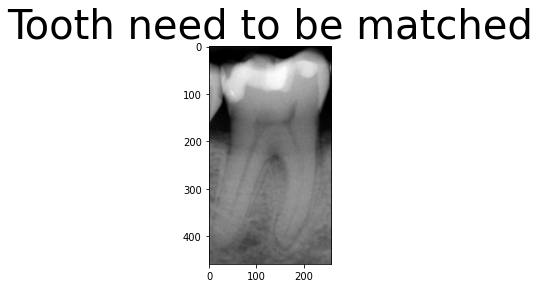

time: 1.34 s (started: 2022-07-04 04:21:36 +00:00)


In [5]:
tooth_dictionary = tooth_extract(img_tooth, img_cej, img_bone_area)




i = 0
for key, value in tooth_dictionary.items():
    
    
    pointA = tooth_dictionary[key][0][1][0]
    pointB = tooth_dictionary[key][1][1][0]
    pointC = tooth_dictionary[key][0][1][1]
    pointD = tooth_dictionary[key][1][1][1]
    pointE = tooth_dictionary[key][4][1][0]
    pointF = tooth_dictionary[key][6][1]
    pointG = tooth_dictionary[key][4][1][1]
    pointH = tooth_dictionary[key][6][2]
    print(pointA, pointB, pointC, pointD, pointE, pointF, pointG,pointH)
    
    template_peri_to_match = image[pointA[1]-150:pointG[1]+40,pointB[0]-40:pointH[0]+150]
    plt.title("Tooth need to be matched" , fontsize = 40)
    plt.imsave('sample_images/extracted_peri_images/s2.png', template_peri_to_match, cmap='gray')
    plt.imshow(template_peri_to_match, cmap='gray')
    i+=1
    if i==2:
        break
